In [ ]:
import dill
dill.load_session('Data/MOD09.db')

In [ ]:
https://github.com/MarcLefevreFr/OpenClassrooms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost
import sklearn
import marko
#import shap
from time import time
from feat_positive_construction import auto_search
from category_encoders.target_encoder import TargetEncoder

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import RFECV
from itertools import combinations

pd.options.display.max_columns = 60

# 1 - APPROCHE EN COMMENCANT DIRECTEMENT PAR DONNEES TRANSFORMEES LOG + STD

# test avec OHE

In [2]:
# choix des métriques : temps, MAE (mois sensible aux outliers) et R2
LISTE_COL = ["Model", "Fit_Time", "Score_time", "MAE", "RMSLE", "R2"] 

SCORING = ["neg_mean_absolute_error", "neg_mean_squared_log_error", "r2"]

SEED = 45

K = 5

df_res = pd.DataFrame(columns = LISTE_COL)
df_no = pd.DataFrame(columns = LISTE_COL)

X = pickle.load(open("Data/X.pickle", "rb"))
y = pickle.load(open("Data/y.pickle", "rb"))

X_no = pickle.load(open("Data/X_no.pickle", "rb"))
y_no = pickle.load(open("Data/y_no.pickle", "rb"))

# On drop EnergyStarScore pour la création des modèles car :
# - il nécessiterait soit de restreindre les données
# - soit de procéder à des imputations qui pourraient nuire à la pertinence de sa discussion.

# X avec EnergyStar
X_es = X.copy()

X = X.drop("ENERGYSTARScore", axis = 1)
X_no = X_no.drop("ENERGYSTARScore", axis = 1)

num_feat = np.array(X.columns[X.dtypes != "category"])
cat_feat = np.array(X.columns[X.dtypes == "category"])

# le premier modèle que nous créons est celui de SiteEnergyUse
y = y["SiteEnergyUseWN(kBtu)"]
y_no = y_no["SiteEnergyUseWN(kBtu)"]

y = y.transform(np.log1p)
y_no = y_no.transform(np.log1p)

In [3]:
log_trans = FunctionTransformer(np.log1p)

ohe = OneHotEncoder(handle_unknown = "ignore")

pipe_num = make_pipeline(log_trans, StandardScaler())

pipe_cat = make_pipeline(ohe)


prepro = make_column_transformer((pipe_num, num_feat), 
                                 (pipe_cat, cat_feat))

#prepro_num = make_column_transformer((pipe_num, num_feat))

In [4]:
linear_reg = make_pipeline(prepro, LinearRegression())
ridge_reg = make_pipeline(prepro, Ridge())
lasso_reg = make_pipeline(prepro, Lasso())
sgd_reg = make_pipeline(prepro, SGDRegressor())
sv_reg = make_pipeline(prepro, SVR())
dt_reg = make_pipeline(prepro, DecisionTreeRegressor())
random_forest_reg = make_pipeline(prepro, RandomForestRegressor())
ada_reg = make_pipeline(prepro, AdaBoostRegressor())
bag_reg = make_pipeline(prepro, BaggingRegressor(base_estimator = DecisionTreeRegressor()))
gb_reg = make_pipeline(prepro, GradientBoostingRegressor())
xgb_reg = make_pipeline(prepro, xgboost.XGBRegressor(random_state = SEED))

modz = {"Linear_Reg" : linear_reg,
        "Ridge_Reg" : ridge_reg,
        "Lasso_Reg" : lasso_reg,
        "sgd_Reg" : sgd_reg,
        "SV_Reg" : sv_reg,
        "dt_Reg" : dt_reg,
        "Random_Forest_Reg" : random_forest_reg,
        "Adaboost_Reg" : ada_reg,
        "Bagging_Reg" : bag_reg,
        "GB_Reg" : gb_reg,
        "XGB_Reg" : xgb_reg
       }

In [5]:
def modelize(model, model_name, X, y, return_model = False , graph = False, k = K) :
        
    resultats = []
    
    kf = KFold(k, random_state = SEED)
    
    cv_res = cross_validate(model, X, y, scoring = SCORING, cv = kf)

    resultats.append(model_name)
    resultats.append(cv_res["fit_time"].sum())
    resultats.append(cv_res["score_time"].sum())
    resultats.append(-cv_res['test_neg_mean_absolute_error'].mean())
    resultats.append(np.sqrt(-cv_res['test_neg_mean_squared_log_error'].mean()))
    resultats.append(cv_res['test_r2'].mean())
    

    if graph :

        pred = cross_val_predict(mod, X, v, cv = kf)

        error = np.abs(target - pred)

        fig = plt.figure(figsize = (8, 8))
        plt.subplot(2,2,1)
        plt.scatter(target, pred, color = "coral")
        plt.subplot(2,2,2)
        plt.hist(error, bins = 50)
        plt.show()
            
#         i += 1
    new_row = {k:v for k, v in zip(LISTE_COL, resultats)}

    if return_model :
        
        return new_row, model.fit(X, y)
        
    else :        
    
    #df = df.append(new_row, ignore_index = True)
    #print(new_row)    
        return new_row

## 1ere modélisation

In [16]:
for name, model in modz.items():
    
    df_res = df_res.append(modelize(model, name, X, y), ignore_index = True)
    
df_res

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.511029,0.047003,0.385290,0.035932,0.691318
1,Ridge_Reg,0.170010,0.048002,0.376535,0.034976,0.708025
2,Lasso_Reg,0.134008,0.044003,0.950983,0.076509,-0.368205
3,sgd_Reg,0.234013,0.047003,0.428637,0.039417,0.630168
4,SV_Reg,2.497143,0.457026,0.384475,0.036806,0.681193
5,dt_Reg,0.703041,0.048002,0.540331,0.049901,0.404400
6,Random_Forest_Reg,43.374481,0.147008,0.402569,0.038024,0.656492
7,Adaboost_Reg,1.540088,0.103006,0.515682,0.044671,0.509685
8,Bagging_Reg,4.510258,0.072004,0.425439,0.039720,0.623585
9,GB_Reg,2.132122,0.052003,0.386518,0.035874,0.693167


### Données sans Outliers

In [17]:
for name, model in modz.items():
    
    df_no = df_no.append(modelize(model, name, X_no, y_no), ignore_index = True)
    
df_no

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.478027,0.047003,0.386835,0.036418,0.634655
1,Ridge_Reg,0.170010,0.045002,0.377887,0.035330,0.657303
2,Lasso_Reg,0.136008,0.044003,0.861349,0.069873,-0.327284
3,sgd_Reg,0.188011,0.048002,0.414066,0.038838,0.586389
4,SV_Reg,2.269130,0.407023,0.378078,0.036318,0.641397
5,dt_Reg,0.648037,0.049003,0.534534,0.049904,0.318544
6,Random_Forest_Reg,38.225186,0.141008,0.405898,0.038439,0.596674
7,Adaboost_Reg,1.540088,0.101006,0.505226,0.044244,0.450507
8,Bagging_Reg,4.017230,0.072004,0.422752,0.039745,0.567349
9,GB_Reg,1.917109,0.061003,0.388597,0.036370,0.637652


Sur cette première étape, les données sans outliers donnent des résultats un peu **MOINS** bons. Sauf PE pour le **SVR**.

## 1er regard sur la variable EnergyStar

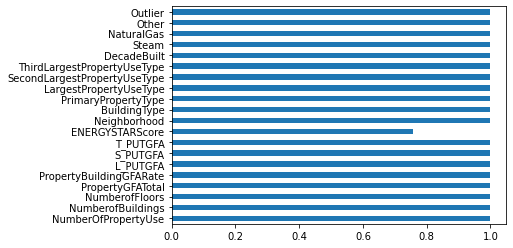

In [9]:
# Cette variable a un grande proportion de valeurs nulles
X_es.notnull().mean().plot.barh()
plt.show()

Plutôt que de les laisser, on les remplit par la valeur mediane de la colone

In [13]:
med = X_es["ENERGYSTARScore"].median()
X_es["ENERGYSTARScore"] = X_es["ENERGYSTARScore"].fillna(med)

75.0

## Discussion sur l'importance de l'ESScore

On regarde pour la **regression linéaire**

In [49]:
liste, mod = modelize(linear_reg, "regression linéaire", X_es, y, True)
liste

{'Model': 'regression linéaire',
 'Fit_Time': 0.5080292224884033,
 'Score_time': 0.04700326919555664,
 'MAE': 0.3852895649964363,
 'RMSLE': 0.03593220022871414,
 'R2': 0.6913181910542765}

0.385290 	0.035932 	0.691318
Les résultat sont un tout petit peu moins bons

In [75]:
# création d'une série avec l'index des features et la valeur du coeff associé
importance = pd.Series(mod.steps[1][1].coef_, range(len(mod.steps[1][1].coef_)))

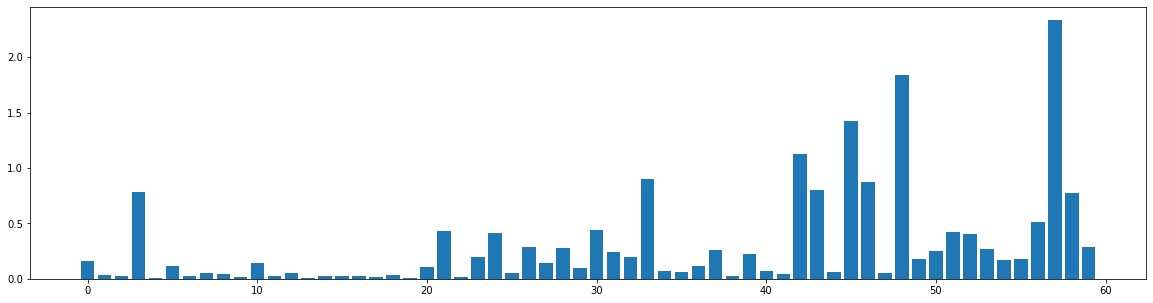

In [83]:
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:60], np.abs(importance.values)[:60])
plt.show()

On regarde pour la **regression ridge**

In [84]:
liste, mod = modelize(ridge_reg, "regression ridge", X_es, y, True)
liste

{'Model': 'regression ridge',
 'Fit_Time': 0.5530319213867188,
 'Score_time': 0.04500222206115723,
 'MAE': 0.37653547183315983,
 'RMSLE': 0.034975885513910274,
 'R2': 0.7080254098009368}

0.376535 - 0.034976 - 0.708025<br>
résultats similaires ou un peu moins bons

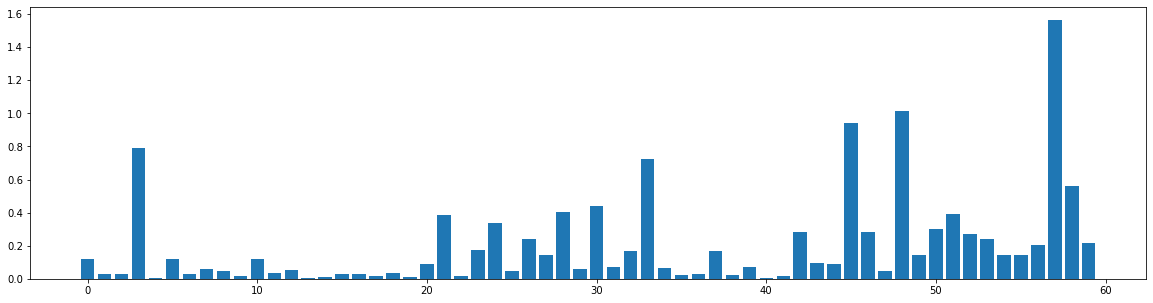

In [86]:
importance = pd.Series(mod.steps[1][1].coef_, range(len(mod.steps[1][1].coef_)))
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:60], np.abs(importance.values)[:60])
plt.show()

Même observations...

On regarde pour la **random forest**

In [87]:
liste, mod = modelize(random_forest_reg, "random forest reg", X_es, y, True)
liste

{'Model': 'random forest reg',
 'Fit_Time': 42.60543656349182,
 'Score_time': 0.14500856399536133,
 'MAE': 0.4023233368202382,
 'RMSLE': 0.03797343077939637,
 'R2': 0.6568272035217481}

0.401665 - 0.037787 - 0.659970<br>Ici le modèle est un peu meilleur

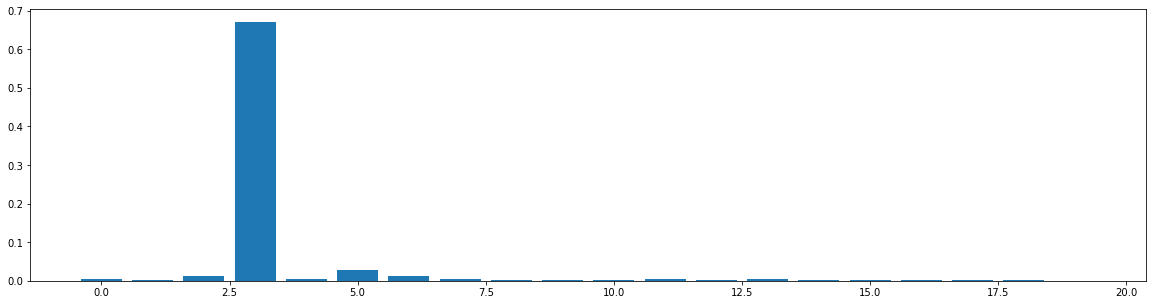

In [93]:
importance = pd.Series(mod.steps[1][1].feature_importances_, 
                       range(len(mod.steps[1][1].feature_importances_)))
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:20], np.abs(importance.values)[:20])
plt.show()

Importance dans cette modélisation RF : 0.13%

In [96]:
mod.steps[1][1].feature_importances_[9]

0.001330544001595828

On regarde pour la **xgboost**

In [101]:
liste, mod = modelize(xgb_reg, "XGBoost", X_es, y, True)
liste

{'Model': 'XGBoost',
 'Fit_Time': 0.837047815322876,
 'Score_time': 0.10600590705871582,
 'MAE': 0.394963548757452,
 'RMSLE': 0.03693588700138334,
 'R2': 0.6761478215590387}

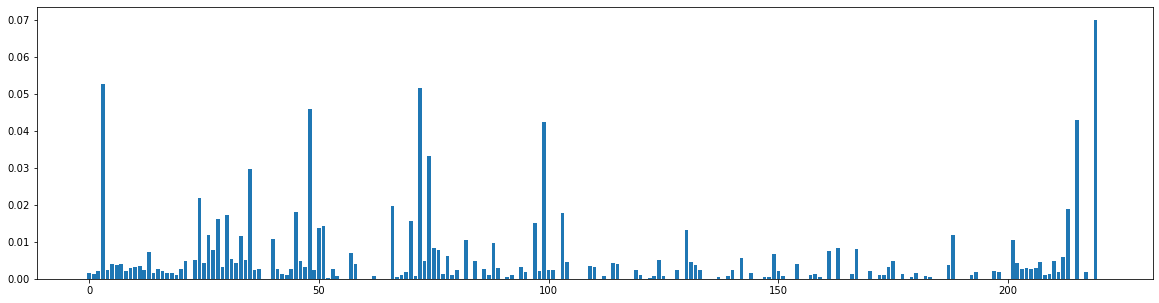

In [115]:
fig = plt.figure(figsize = (20,5))
plt.bar(range(len(mod.steps[1][1].feature_importances_)), mod.steps[1][1].feature_importances_)
plt.show()

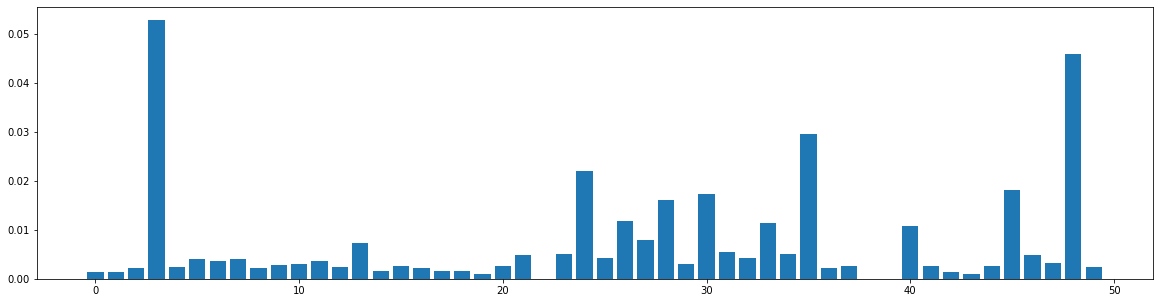

In [119]:
# zoom
fig = plt.figure(figsize = (20,5))
plt.bar(range(len(mod.steps[1][1].feature_importances_[:50])), 
        mod.steps[1][1].feature_importances_[:50])
plt.show()

In [118]:
mod.steps[1][1].feature_importances_[9]

0.0028108903

Avec XGBoost, l'indicateur compte pour **0.28%**.

# Travail sur les variables catégorielles

## Test avec Label Encoding

Ca devrait modifier les résultats de nos modèles linéaires mais peut-être améliorer les résultats des autres.

On va encoder nos données en amont du pipeline qui devra être aussi modifié...

In [7]:
X_lab = X.copy()

for cat in cat_feat :
    lab_enc = LabelEncoder()
    X_lab[cat] = lab_enc.fit_transform(X_lab[cat])

In [6]:
prepro_ord = make_column_transformer((pipe_num, num_feat))

linear_reg_ord = make_pipeline(prepro_ord, LinearRegression())
ridge_reg_ord = make_pipeline(prepro_ord, Ridge())
lasso_reg_ord = make_pipeline(prepro_ord, Lasso())
sv_reg_ord = make_pipeline(prepro_ord, SVR())
random_forest_reg_ord = make_pipeline(prepro_ord, RandomForestRegressor())
ada_reg_ord = make_pipeline(prepro_ord, AdaBoostRegressor())
bag_reg_ord = make_pipeline(prepro_ord, BaggingRegressor(base_estimator = DecisionTreeRegressor()))
gb_reg_ord = make_pipeline(prepro_ord, GradientBoostingRegressor())
xgb_reg_ord = make_pipeline(prepro_ord, xgboost.XGBRegressor(random_state = SEED))
xgbrf_reg_ord = make_pipeline(prepro_ord, xgboost.XGBRFRegressor(random_state = SEED))


mod_lab = {"Linear_Reg_ord" : linear_reg_ord,
        "Ridge_Reg_ord" : ridge_reg_ord,
        "Lasso_Reg_ord" : lasso_reg_ord,
        "SV_Reg_ord" : sv_reg_ord,
        "Random_Forest_Reg_ord" : random_forest_reg_ord,
        "Adaboost_Reg_ord" : ada_reg_ord,
        "Bagging_Reg_ord" : bag_reg_ord,
        "GB_Reg_ord" : gb_reg_ord,
        "XGB_Reg_ord" : xgb_reg_ord
}

In [35]:
df_res_lab = pd.DataFrame(columns = LISTE_COL)

for name, model in mod_lab.items():
    
    df_res_lab = df_res_lab.append(modelize(model, name, X_lab, y), ignore_index = True)
    
df_res_lab

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg_ord,0.070004,0.027002,0.515628,0.044676,0.516688
1,Ridge_Reg_ord,0.148008,0.017001,0.515673,0.044678,0.516670
2,Lasso_Reg_ord,0.060003,0.019001,0.950983,0.076509,-0.368205
3,SV_Reg_ord,1.280073,0.149009,0.508188,0.045991,0.495250
4,Random_Forest_Reg_ord,3.474199,0.105006,0.531574,0.047102,0.468096
5,Adaboost_Reg_ord,0.591034,0.045003,0.544728,0.047159,0.457702
6,Bagging_Reg_ord,0.407023,0.030002,0.555233,0.048728,0.429877
7,GB_Reg_ord,1.055060,0.023001,0.500724,0.044311,0.528737
8,XGB_Reg_ord,0.665038,0.035002,0.530976,0.046922,0.470463


Résultats très mauvais !!!

## test avec Target_encoding

Le Target encoding consiste à remplacer les catégories d'une variable par .

In [14]:
X_tar = X.copy()
var_str = ['Neighborhood', 'BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'DecadeBuilt']

# for cat in var_str :
#     tar_enc = TargetEncoder()
#     X_tar[cat] = tar_enc.fit_transform(X_tar[cat], y)

In [15]:
pipe_tar = make_pipeline(TargetEncoder(), StandardScaler())

prepro_tar = make_column_transformer((pipe_num, num_feat), 
                                     (pipe_tar, var_str))

linear_reg_tar = make_pipeline(prepro_tar, LinearRegression())
ridge_reg_tar = make_pipeline(prepro_tar, Ridge())
lasso_reg_tar = make_pipeline(prepro_tar, Lasso())
sv_reg_tar = make_pipeline(prepro_tar, SVR())
random_forest_reg_tar = make_pipeline(prepro_tar, RandomForestRegressor())
ada_reg_tar = make_pipeline(prepro_tar, AdaBoostRegressor())
bag_reg_tar = make_pipeline(prepro_tar, BaggingRegressor(base_estimator = DecisionTreeRegressor()))
gb_reg_tar = make_pipeline(prepro_tar, GradientBoostingRegressor())
xgb_reg_tar = make_pipeline(prepro_tar, xgboost.XGBRegressor(random_state = SEED))
xgbrf_reg_tar = make_pipeline(prepro_tar, xgboost.XGBRFRegressor(random_state = SEED))

mod_tar = {"Linear_Reg_tar" : linear_reg_tar,
        "Ridge_Reg_tar" : ridge_reg_tar,
        "Lasso_Reg_tar" : lasso_reg_tar,
        "SV_Reg_tar" : sv_reg_tar,
        "Random_Forest_Reg_tar" : random_forest_reg_tar,
        "Adaboost_Reg_tar" : ada_reg_tar,
        "Bagging_Reg_tar" : bag_reg_tar,
        "GB_Reg_tar" : gb_reg_tar,
        "XGB_Reg_tar" : xgb_reg_tar
}

In [16]:
df_res_tar = pd.DataFrame(columns = LISTE_COL)

for name, model in mod_tar.items():
    
    df_res_tar = df_res_tar.append(modelize(model, name, X_tar, y), ignore_index = True)
    
df_res_tar

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg_tar,1.370003,0.155001,0.434529,0.039816,0.619560
1,Ridge_Reg_tar,0.751001,0.110000,0.434559,0.039818,0.619539
2,Lasso_Reg_tar,0.716004,0.125001,0.950983,0.076509,-0.368205
3,SV_Reg_tar,1.942002,0.270001,0.441003,0.041459,0.592305
4,Random_Forest_Reg_tar,5.350008,0.190001,0.423985,0.039264,0.632480
5,Adaboost_Reg_tar,1.361002,0.132000,0.517307,0.044774,0.513083
6,Bagging_Reg_tar,1.155004,0.120000,0.440452,0.040572,0.606043
7,GB_Reg_tar,2.002003,0.100001,0.417436,0.038711,0.642554
8,XGB_Reg_tar,1.375044,0.184010,0.440253,0.040946,0.602483


Option non concluante...

# Selection des models

Suite à nos précédents résultats, on décide de garder les models les plus prometteurs qu'on pense de plus pouvoir encore améliorer plus tard :<br>- ridge<br>- svr<br>- GB<br>- XGB

# Réduction dimensionnelle des var_cat

### Utilisation de la fonction **Optimize_Level**

In [23]:
# En fonction d'un level "n", et d'une colonne "col" (d'une variable catégorielle) d'un DF "df", 
# cette méthode renvoie une colonne "col" réduite à "n" différentes valeurs. le surplus est
# remplacé par "No_Data" ou des "0"

def level_n_reductor(n, df, col):
    
    df1 = df.copy()
    
    top = df1[col].value_counts().index.tolist()[:n]

    labels = df1[col].value_counts().index.tolist()
    
    type_data = type(labels[0])
    
    if type_data is str :
    
        new = [l if l in top else "No_Data" for l in labels]
    
    else :
        
        new = [l if l in top else 0 for l in labels]
    
    dico = {k:v for k, v in zip(labels, new)}
    
    df1[col] = df1[col].map(dico)
    #df1[col] = df1[col].map(dico).astype("category")
    
    nb = df1[col].unique().shape[0]
    
    return df1, nb



# modélisation renvoyant les résultats dans la métrique "key"

def modeli(n, model, X, y, key) :
        
    resultats = [n]
    
    kf = KFold(K, random_state = SEED)
    
    cv_res = cross_validate(model, X, y, scoring = SCORING, cv = kf)
    
    dict_metrics = {"MAE" : -cv_res['test_neg_mean_absolute_error'].mean(), 
                    "RMSLE" : np.sqrt(-cv_res['test_neg_mean_squared_log_error'].mean()), 
                    "R2" : cv_res['test_r2'].mean()}
    
    resultats.append(dict_metrics[key])
#     if np.isnan(dict_metrics[key]) :
#         print("NAN !!!")
#         print(model.fit_transform(X))
    
    return resultats


# Pour un df, un model, et une métrique donnés, cette méthode cherche le meilleur level de chaque
# variable catégorielle en allant de la varcat la PLUS PROFONDE à la MOINS PROFONDE.

def optimize_level(model, model_name, df, y, key):
    
    X = df.copy()

    # init de listes
    liste = []
    liste_best = []
    liste_X_trans = []
    liste_indice = []
    
    # listage des var cat d'un DF
    liste_var_cat = X.select_dtypes(include="category").columns.to_list()
    
    # création d'une série (classé decroi.) de ces varcat avec leur level en index
    s = pd.Series([k for k in liste_var_cat], 
                  index = [X[var].unique().shape[0] for var in liste_var_cat]).sort_index(ascending = False)

    # boucle dans la série    
    for col, n in zip(s.values, s.index) :

        #print(f"On est dans col - {col} - qui a - {n} - val.")

        # init de listes
        liste_X = []
        liste_n = []

        # pour la colonne col, on crée une liste de df ou col a son level diminué de n à 1
        for i in range(n, 0, -1) : # yo +1

            liste_X.append(level_n_reductor(i, X, col)[0])
            liste_n.append(level_n_reductor(i, X, col)[1])

        liste_b = []
        i = 0
        
        # ensuite on calcul le score pour chaque df
        for df, nb in zip(liste_X, liste_n) :

            #df = pd.get_dummies(X, drop_first = True)
            liste_b.append([i] + list(modeli(nb, model, df, y, key))) #yoooo +1
            i += 1

        # on récupère meileur score et meilleur indice n correspondant
        ar_b = np.array(liste_b)
        best = np.min(ar_b, axis = 0)[2]
        ind = np.argmin(ar_b, axis = 0)[2]
        best_n = int(ar_b[ind][1])
        
        liste.append(liste_b)
        liste_best.append((i, ind, best, best_n))
        liste_indice.append(best_n)
        
        X = liste_X[ind]
        
        liste_X_trans.append(X)
        
    # sortie de la boucle, on va drop les varcat devenues cstabaissées à un elem et tou mettre en dtype cat    
    #print("post-traitement")
    
    X_opti = liste_X_trans[-1]
    
    #print(liste_best)
    
    for col in liste_var_cat :
            
        #print(X_opti[col].dtype.name)

        if X_opti[col].dtype.name != "category" :

            #print(f"On met {col} en type 'category'")                    
            X_opti[col] = X_opti[col].astype("category")  
    
    drop = False
    
    for col in liste_var_cat :

        #print(X_opti[col].dtype, " - ", X_opti[col].dtype.name)

        #print(X_opti[col].unique().shape[0])
        if X_opti[col].unique().shape[0] == 1 :

            #print(f"On drop la colonne : {col}")
            X_opti = X_opti.drop(col, axis = 1)
            drop = True
    
#     if drop :
#         #print(X_opti.info())
#         liste_best.append(list(modeli("Score apres drop", model, X_opti, y, key)))
    
    #liste_resultats = [model_name, liste_indice, liste_best[-1][2]]
    
    # on retourne les meilleurs score et indice, ainsi que le df ainsi "optimisé"
    #return liste_best, liste_X_trans[-1]
    return liste_best, model_name, liste_best[-1][2], X_opti

## Diminution level des feat catég.

In [24]:
# 2
red_level_res = []

mod3 = {#"Linear_Reg" : linear_reg,
        "Ridge_Reg" : ridge_reg,
        "SV_Reg" : sv_reg,
        "GB_Reg" : gb_reg,
        "XGB_Reg" : xgb_reg
}

for name, mod in mod3.items() :
#for name, mod in zip(modz.keys()[:2], modz.values()[:2]) :
    start = time()
    print(f"on est avec le modele {name}")
    red_level_res.append(optimize_level(mod, name, X, y, "MAE"))
    print(red_level_res[-1][1], red_level_res[-1][2])
    print(f"on a mis {time() - start}")
    print()

for l in red_level_res :
    
    print(l[1], l[2], f"{len(X.columns) - len(l[3].columns)} colonnes drop")

on est avec le modele Ridge_Reg
Ridge_Reg 0.37141008664650793
on a mis 52.12998175621033

on est avec le modele SV_Reg
SV_Reg 0.3801521824231815
on a mis 631.2921078205109

on est avec le modele GB_Reg
GB_Reg 0.38072501956496857
on a mis 461.51739716529846

on est avec le modele XGB_Reg
XGB_Reg 0.38918630718594294
on a mis 251.54638767242432

Ridge_Reg 0.37141008664650793 2 colonnes drop
SV_Reg 0.3801521824231815 2 colonnes drop
GB_Reg 0.38072501956496857 0 colonnes drop
XGB_Reg 0.38918630718594294 0 colonnes drop


In [26]:
# sauvegardes des data
pickle_out = open("Data/red_level_res.pickle", "wb")
pickle.dump(red_level_res, pickle_out)
pickle_out.close()

In [27]:
liste_X_opti = []

for n in range(len(red_level_res)) :
    liste_X_opti.append(red_level_res[n][3])

In [28]:
# sauvegardes liste des df optimisés
pickle_out = open("Data/liste_X_opti.pickle", "wb")
pickle.dump(liste_X_opti, pickle_out)
pickle_out.close()

Maintenant, chaque estimateur aura son DF de features associés...

In [ ]:
# rechargement des df...

In [8]:
liste_X = pickle.load(open("Data/liste_X_opti.pickle", "rb"))

X_ridge = liste_X[0]
X_svr = liste_X[1]
X_GB = liste_X[2]
X_XGB = liste_X[3]

# Définition des pipeline "opti level "

In [9]:
# X_ridge = liste_X[1]
# X_svr = liste_X[2]
# X_GB = liste_X[3]
# X_XGB = liste_X[4]

liste_estimator = [Ridge(), SVR(), GradientBoostingRegressor(), 
                   xgboost.XGBRegressor(random_state = SEED)]
liste_pipeline_opti = []

for df in liste_X :
    
    nu_feat = np.array(df.columns[df.dtypes != "category"])
    ca_feat = np.array(df.columns[df.dtypes == "category"])
    
    log_trans = FunctionTransformer(np.log1p)

    ohe = OneHotEncoder(handle_unknown = "ignore")

    pip_num = make_pipeline(log_trans, StandardScaler())

    pip_cat = make_pipeline(ohe)


    prepro = make_column_transformer((pip_num, nu_feat), 
                                     (pip_cat, ca_feat))
    
    liste_pipeline_opti.append(prepro)
    
    
ridge_ol = make_pipeline(liste_pipeline_opti[0], liste_estimator[0])
svr_ol = make_pipeline(liste_pipeline_opti[1], liste_estimator[1])
gb_ol = make_pipeline(liste_pipeline_opti[2], liste_estimator[2])
xgb_ol = make_pipeline(liste_pipeline_opti[3], liste_estimator[3])

modz_ol = {"ridge_ol" : (ridge_ol, liste_pipeline_opti[0], liste_X[0]),
          "svr_ol" : (svr_ol, liste_pipeline_opti[1], liste_X[1]),
          "gb_ol" : (gb_ol, liste_pipeline_opti[2], liste_X[2]),
          "xgb_ol" : (xgb_ol, liste_pipeline_opti[3], liste_X[3])}

# modz_ol = {"ridge_ol" : (ridge_ol, X_ridge),
#           "svr_ol" : (svr_ol, X_svr),
#           "gb_ol" : (gb_ol, X_GB),
#           "xgb_ol" : (xgb_ol, X_XGB)}

In [16]:
# vérification que tout correspond bien...
df_res_ol = pd.DataFrame(columns = LISTE_COL)

for name, mod in modz_ol.items():
    
    df_res_ol = df_res_ol.append(modelize(mod[0], name, mod[2], y), ignore_index = True)
    
df_res_ol

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,ridge_ol,0.159009,0.040002,0.371402,0.034757,0.712638
1,svr_ol,2.266129,0.400023,0.382567,0.036689,0.683363
2,gb_ol,1.982114,0.051003,0.380394,0.035573,0.698400
3,xgb_ol,137.959890,0.117007,0.389186,0.036565,0.683449


Petite amélioration des résultats... On garde cette option !

# Feature Sélection avec RFECV

In [8]:
liste_X_tr = [liste_pipeline_opti[n].fit_transform(liste_X[n]) for n in range(4)]

In [50]:
for df in liste_X_tr :
    print(df.shape)

(3303, 133)
(3303, 138)
(3303, 113)
(3303, 170)


**Ridge**

In [9]:
selector = RFECV(estimator=Ridge(), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_ridge_rfe = selector.fit_transform(liste_X_tr[0], y)

print(selector.ranking_)
print(np.sqrt(-selector.grid_scores_))
print(liste_X_tr[0].shape)
print(X_ridge_rfe.shape)

[ 1  1  5  1 14  1  1  1 11  9  1  4  1  1  1  1  1  1  1  1  1  1  1  1
  1 13  2  1  1  1 12  6  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  3  1  1  1  7  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  8 15  1  1  1  1  1]
[0.0755801  0.07527613 0.07508608 0.07467854 0.0739043  0.07373474
 0.07374569 0.07362883 0.06993939 0.06331129 0.06321782 0.06322798
 0.05917703 0.05907913 0.05903917 0.04198145 0.04188053 0.04152281
 0.04149592 0.04139551 0.04058116 0.04062104 0.04002355 0.03939419
 0.0384394  0.03846571 0.03835784 0.03723996 0.03725084 0.03690314
 0.03629593 0.03626377 0.03618899 0.03610152 0.03609469 0.03609387
 0.03608806 0.03603197 0.03595779 0.03597037 0.03595534 0.03594039
 0.03587276 0.0358667  0.03587828 0.03587182 0.03585332 0.03585212
 0.03586269 0.03586615 0.03586834 0.03580255 0.03577084 0.

In [10]:
modelize(Ridge(), "ridge_rfe", X_ridge_rfe, y)

{'Model': 'ridge_rfe',
 'Fit_Time': 0.054003238677978516,
 'Score_time': 0.007000446319580078,
 'MAE': 0.37036859007956635,
 'RMSLE': 0.0346653317573047,
 'R2': 0.714244890972922}

**SVR**

In [11]:
selector = RFECV(estimator=SVR(kernel = "linear"), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_svr_rfe = selector.fit_transform(liste_X_tr[1], y)

print(selector.ranking_)
print(np.sqrt(-selector.grid_scores_))
print(liste_X_tr[1].shape)
print(X_svr_rfe.shape)

[ 1 18 28  1 25  1 20  7 16  3  2  1  1  1  1 10  1  1  1  1  1 27  8 19
 26  1  9  1  1  1  1  4  1  1  1  1  1  1  1  1  1  1  1 30  1  1  1  1
  1  1  1  1  1 22 17  1  1  1  1  1  1  1  1  1  1 38  1  1  1  1  1  1
  1 33  1  1  1  1  1  1  1  1  1 32  1  1  1  1  1  1  1  1  1  1 31  1
  1  6  1 24  1  1  1 21  1  1 34 23 35  1 37  1  1  1  1 36 15  1  1  1
  5  1 14 13  1  1  1  1  1  1 29 12 11  1  1  1  1  1]
[0.07559606 0.07513101 0.07476925 0.07424797 0.073976   0.0740028
 0.07398904 0.07390315 0.07386111 0.07376807 0.07071164 0.0684604
 0.06515904 0.06168409 0.06166231 0.04268083 0.04252998 0.04268878
 0.04228232 0.04220734 0.04210909 0.04202088 0.04186179 0.04166513
 0.04130158 0.04128437 0.04105755 0.04100458 0.04061268 0.03927952
 0.03914821 0.03790341 0.03728739 0.03721859 0.03712813 0.03645527
 0.03645877 0.03644382 0.03644783 0.03643624 0.03641389 0.03633316
 0.03633443 0.03633444 0.0362367  0.03624779 0.03620418 0.03622657
 0.03630153 0.03631778 0.03634552 0.03620483 

In [12]:
modelize(SVR(), "svr_rfe", X_svr_rfe, y)

{'Model': 'svr_rfe',
 'Fit_Time': 1.7350993156433105,
 'Score_time': 0.26601529121398926,
 'MAE': 0.3653921377522994,
 'RMSLE': 0.035473732504030756,
 'R2': 0.7027934126499905}

**GB**

In [13]:
selector = RFECV(estimator=GradientBoostingRegressor(), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_gb_rfe = selector.fit_transform(liste_X_tr[2], y)

print(selector.ranking_)
print(np.sqrt(-selector.grid_scores_))
print(liste_X_tr[2].shape)
print(X_gb_rfe.shape)

[ 1  1  1  1  1  1  1  1 24  3  1  7  1 21  1 29 18 39 11  4 40 38 46  1
  1  1  1  9  1 13 51 28  1 25  1  5 64 45  1  1 54 55  1  2  1 56 57  1
 53  1  1 32  1  1  1  1 41  1  1  1 27 31 49 44  1 52 10 17 20 61  1 30
 35 36 42  1 34 50 12 65 33 62 26 16  1 47 48 37 59 60 43 63 14 19  1  1
  1  1  1  1  6 15  1 58  1  1  8  1  1 22 23  1  1]
[0.04588342 0.04295896 0.04184428 0.04081638 0.0407158  0.04022865
 0.03973793 0.0386836  0.03817594 0.03740964 0.03735721 0.0372895
 0.03708686 0.03668619 0.03662052 0.03648548 0.03643111 0.03626583
 0.03626659 0.03594138 0.03597709 0.03589827 0.03597386 0.03577627
 0.03575766 0.03585062 0.03571306 0.03563789 0.03574523 0.03571341
 0.03580645 0.03574944 0.03567164 0.03574141 0.03571853 0.03578071
 0.03574626 0.03555356 0.03554921 0.03560846 0.03561315 0.03557458
 0.0355484  0.03557947 0.03553525 0.0356442  0.03553706 0.0355326
 0.03552297 0.03566153 0.03563109 0.03562703 0.03567444 0.03565434
 0.03558598 0.03558615 0.03556284 0.03556635 0.0356209

In [14]:
modelize(GradientBoostingRegressor(), "gb_rfe", X_gb_rfe, y)

{'Model': 'gb_rfe',
 'Fit_Time': 1.6290936470031738,
 'Score_time': 0.01300048828125,
 'MAE': 0.3808636576083209,
 'RMSLE': 0.0355344574087121,
 'R2': 0.6990871784060853}

**XGB**

In [15]:
selector = RFECV(estimator = xgboost.XGBRegressor(random_state = SEED), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_xgb_rfe = selector.fit_transform(liste_X_tr[3], y)

print(selector.ranking_)
print(selector.grid_scores_)
print(liste_X_tr[3].shape)
print(X_xgb_rfe.shape)

[ 1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  1 35  1  1  1  1
  1  1  1  1  1 36  1  1  1  1  1  1  1  1  1  1  1  1 27  1  6 24  1  1
  1  1  1  1  1  1  1  1  1  1 34  3  1  1  1 51  1  1  1 53  1  1  1 19
 47 48  1  1  9 37  1 41  1 57  1  1  1 31  1 21  1 33  1  1 29  1 28  1
 11  7 45  8  1  1  1 44  1 23 15 49  5 56  1 58  1 55 54  1  1 50 39  1
 46  1  1 38  1  2  1 30  1  1 26 22  1 40 42 43  1  1  1 10 12  1  1 32
 25 13 18  1 14 20  1  1  1  1  1  1  1  1  1  1  1  1  1 16  1 17  1 52
  1 59]
[-0.00548623 -0.00449257 -0.0033814  -0.00331132 -0.00207608 -0.00186493
 -0.00183099 -0.00179828 -0.0017868  -0.00174034 -0.00171348 -0.00172873
 -0.00170076 -0.00167898 -0.00165819 -0.00164666 -0.001643   -0.00162928
 -0.00155678 -0.00156353 -0.00154439 -0.0015641  -0.00152732 -0.00153374
 -0.00150572 -0.00153856 -0.00152946 -0.00150597 -0.00149992 -0.00151089
 -0.00151073 -0.00149366 -0.0015066  -0.00148057 -0.00144218 -0.0014503
 -0.0014387  -0.00144    -0.00142061 -0.0014

In [16]:
modelize(xgboost.XGBRegressor(random_state = SEED), "xgb_rfe", X_xgb_rfe, y)

{'Model': 'xgb_rfe',
 'Fit_Time': 0.6990399360656738,
 'Score_time': 0.04600262641906738,
 'MAE': 0.3929662103099294,
 'RMSLE': 0.036946682274464133,
 'R2': 0.6771890770986392}

# Pas d'amélioration pour XGB ! <--- PB ???

In [17]:
X_xgb_rfe = liste_X_tr[3]

In [18]:
liste_X_post_rfe = [X_ridge_rfe, X_svr_rfe, X_gb_rfe, X_xgb_rfe]

In [19]:
pickle_out = open("Data/liste_X_post_rfe.pickle", "wb")
pickle.dump(liste_X_post_rfe, pickle_out)
pickle_out.close()

In [10]:
liste = pickle.load(open("Data/liste_X_post_rfe.pickle", "rb"))

X_ridge_rfe = liste[0]
X_svr_rfe = liste[1]
X_gb_rfe = liste[2]
X_xgb_rfe = liste[3]

# Select k Best

In [22]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression

**Ridge**

In [23]:
f_regression(X_ridge_rfe, y)

(array([2.65517529e+02, 1.10992885e+02, 5.65966636e+03, 2.93728877e+01,
        1.27410627e+02, 5.42943280e+01, 1.60867233e+02, 5.41474587e+02,
        1.01211956e-01, 6.57402749e+01, 1.76542640e+02, 1.93935580e+01,
        5.65773479e+00, 9.81989698e+00, 1.14273764e+02, 1.02850842e+02,
        8.47065484e+01, 2.82476567e+00, 4.07312463e+01, 4.78387830e+02,
        4.70928066e-01, 1.33008472e+01, 2.22263333e-01, 2.30427813e-01,
        1.30069268e+00, 3.20944085e+01, 3.77961378e+01, 2.72250885e+00,
        6.49260585e+01, 1.61081497e+01, 5.53883618e+01, 3.80158069e+01,
        2.54665282e-03, 1.46529387e-01, 6.57938742e-01, 1.61081497e+01,
        7.12774111e+00, 2.31144204e+01, 1.01000425e+01, 3.38099248e-01,
        1.25630293e-01, 2.42157497e+00, 3.23442180e+00, 1.02850842e+02,
        8.64093467e+01, 2.82476567e+00, 4.83191749e+01, 8.80873583e-02,
        6.97371954e+00, 6.84502174e-01, 3.78477997e+01, 3.66412040e-02,
        3.14443453e+02, 1.46494243e+00, 1.16772470e+00, 5.425971

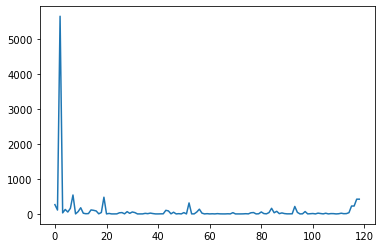

In [24]:
plt.plot(f_regression(X_ridge_rfe, y)[0])
plt.show()

In [30]:
df_perc_ridge = pd.DataFrame(columns = ["p"] + LISTE_COL )

for p in range(0, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_ridge_perc = selector.fit_transform(X_ridge_rfe, y)
    df_perc_ridge = df_perc_ridge.append(dict({"p" : p}, **modelize(Ridge(), "Ridge", X_ridge_perc, y)), ignore_index = True)
    
df_perc_ridge.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
77,77,Ridge,0.046002,0.006001,0.370575,0.034561,0.716380
81,81,Ridge,0.045003,0.005001,0.370495,0.034563,0.716363
76,76,Ridge,0.047002,0.005001,0.370488,0.034564,0.716386
80,80,Ridge,0.047002,0.005001,0.370456,0.034565,0.716351
78,78,Ridge,0.048003,0.005000,0.370551,0.034568,0.716280


In [31]:
X_ridge_perc = SelectPercentile(f_regression, 77).fit_transform(X_ridge_rfe, y)
X_ridge_perc.shape

(3303, 91)

**SVR**

In [33]:
df_perc_svr = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_svr_perc = selector.fit_transform(X_svr_rfe, y)
    df_perc_svr = df_perc_svr.append(dict({"p" : p}, **modelize(SVR(), "SVR", X_svr_perc, y)), 
                                     ignore_index = True)
    
df_perc_svr.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
50,100,SVR,1.690097,0.258014,0.365392,0.035474,0.702793
46,96,SVR,1.681094,0.261015,0.366461,0.035503,0.702611
47,97,SVR,1.680096,0.260015,0.366508,0.035506,0.702570
45,95,SVR,1.665095,0.260015,0.366621,0.035512,0.702439
44,94,SVR,1.706098,0.259015,0.366621,0.035513,0.702411


Pas d'améliorations

In [34]:
X_svr_perc = X_svr_rfe

**GB**

In [37]:
df_perc_GB = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_gb_perc = selector.fit_transform(X_gb_rfe, y)
    df_perc_GB = df_perc_GB.append(dict({"p" : p}, **modelize(liste_estimator[2], "GB", X_gb_perc, y)), 
                                   ignore_index = True)
    
df_perc_GB.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
41,91,GB,1.587091,0.012000,0.379796,0.035469,0.699677
40,90,GB,1.604091,0.014001,0.380028,0.035475,0.699687
47,97,GB,1.628093,0.014001,0.380278,0.035478,0.700070
46,96,GB,1.667095,0.014000,0.380543,0.035491,0.699924
45,95,GB,1.601092,0.013001,0.380541,0.035514,0.699470


In [41]:
X_gb_perc = SelectPercentile(f_regression, 91).fit_transform(X_gb_rfe, y)

**XGB**

In [44]:
df_perc_XGB = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_xgb_perc = selector.fit_transform(X_xgb_rfe, y)
    df_perc_XGB = df_perc_XGB.append(dict({"p" : p}, **modelize(liste_estimator[3], "XGB", X_xgb_perc, y)), 
                                     ignore_index = True)
    
df_perc_XGB.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
39,89,XGB,0.638036,0.048003,0.388674,0.036325,0.687307
38,88,XGB,0.760043,0.049003,0.387799,0.036380,0.686504
41,91,XGB,0.648037,0.047003,0.389246,0.036410,0.686330
35,85,XGB,2.250129,0.047003,0.389759,0.036530,0.682563
33,83,XGB,1.357078,0.058003,0.389622,0.036539,0.682785


In [45]:
X_xgb_perc = SelectPercentile(f_regression, 89).fit_transform(X_xgb_rfe, y)
X_xgb_perc.shape

(3303, 151)

In [57]:
liste_X_perc = [X_ridge_perc, X_svr_perc, X_gb_perc, X_xgb_perc]

In [58]:
pickle_out = open("Data/liste_X_perc.pickle", "wb")
pickle.dump(liste_X_perc, pickle_out)
pickle_out.close()

# GRIDSEARCH

In [12]:
liste_X_gs = pickle.load(open("Data/liste_X_perc.pickle", "rb"))

X_ridge_gs = liste_X_gs[0]
X_svr_gs = liste_X_gs[1]
X_gb_gs = liste_X_gs[2]
X_xgb_gs = liste_X_gs[3]

## Ridge

In [61]:
param_ridge = {"alpha" : np.logspace(0.001, 1, 50)}
ridge_grid = GridSearchCV(Ridge(), param_ridge, scoring = "neg_mean_squared_log_error")
ridge_grid.fit(X_ridge_gs, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 1.00230524,  1.05047992,  1.10097006,  1.15388696,  1.20934725,
        1.26747317,  1.32839285,  1.39224057,  1.45915706,  1.52928981,
        1.60279342,  1.6798299 ,  1.76056904,  1.84518883,  1.93387577,
        2.02682535,  2.12424244,  2.22634178,  2.33334841,  2.4454982 ,
        2.56303834,  2.68622791,  2.81533845,  2.95065455,  3.09247447,
        3.2411108 ,  3.39689117,  3.56015895,  3.73127401,  3.91061352,
        4.0985728 ,  4.29556612,  4.5020277 ,  4.71841264,  4.94519787,
        5.18288328,  5.43199278,  5.69307544,  5.96670675,  6.25348985,
        6.55405685,  6.86907027,  7.19922446,  7.54524714,  7.90790101,
        8.28798544,  8.6863382 ,  9.10383735,  9.54140312, 10.        ])},
             scoring='neg_mean_squared_log_error')

In [62]:
ridge_grid.best_params_

{'alpha': 1.0504799196403356}

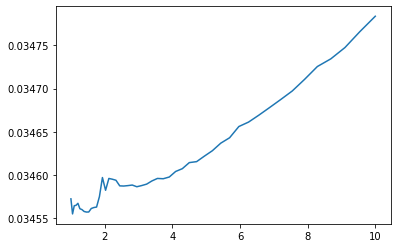

In [63]:
score = np.sqrt(- ridge_grid.cv_results_["mean_test_score"])
plt.plot(np.logspace(0.001, 1, 50), score)

In [63]:
np.sqrt(-max(ridge_grid.cv_results_["mean_test_score"]))

0.034555121320351205

In [64]:
best_ridge = ridge_grid.best_estimator_
modelize(best_ridge, "best_ridge", X_ridge_gs, y)

{'Model': 'best_ridge',
 'Fit_Time': 0.05600285530090332,
 'Score_time': 0.007000446319580078,
 'MAE': 0.37042619270802196,
 'RMSLE': 0.034555121320351205,
 'R2': 0.7164971789476553}

## Ridge sans outlier

In [44]:
scr = SVR()

## SVR

In [45]:
# param_SVR = {"kernel" : ["rbf"], 
#              "gamma" : ["scale"], 
#              "C" : [0.1, 1, 10, 20, 100, 500, 1000, 10000],
#              "epsilon" : [0.1, 0.5, 1]
#             }

svr_grid = GridSearchCV(SVR(), 
                        param_SVR, 
                        scoring = "neg_mean_absolute_error", 
                        cv = K)

In [46]:
start = time()
svr_grid.fit(X_svr_gs, y)
print(time()-start)

643.9958343505859


In [50]:
svr = svr_grid.best_estimator_
svr_grid.best_params_

{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

In [51]:
modelize(svr, "best_svr", X_svr_gs, y)

{'Model': 'best_svr',
 'Fit_Time': 1.909109354019165,
 'Score_time': 0.2930166721343994,
 'MAE': 0.3653921377522994,
 'RMSLE': 0.035473732504030756,
 'R2': 0.7027934126499905}

In [52]:
param_SVR2 = {"kernel" : ["rbf"], 
             "gamma" : ["scale"], 
             "C" : [0.5, 1, 1.5],
             "epsilon" : [0.01, 0.05, 0.1, 0.15]
            }

svr_grid2 = GridSearchCV(SVR(), 
                        param_SVR2, 
                        scoring = "neg_mean_absolute_error", 
                        cv = K)

In [53]:
start = time()
svr_grid2.fit(X_svr_gs, y)
print(time()-start)

28.099607229232788


In [54]:
svr2 = svr_grid2.best_estimator_
svr_grid2.best_params_

{'C': 1.5, 'epsilon': 0.15, 'gamma': 'scale', 'kernel': 'rbf'}

In [55]:
modelize(svr2, "best_svr", X_svr_gs, y)

{'Model': 'best_svr',
 'Fit_Time': 1.6160919666290283,
 'Score_time': 0.23301386833190918,
 'MAE': 0.36352157146239256,
 'RMSLE': 0.035316657369804966,
 'R2': 0.7049858002235844}

In [104]:
param_SVR = {"kernel" : ["rbf"], 
             "gamma" : ["auto"], 
             "C" : np.linspace(19, 19.9, 10)
            }
svr_grid2 = GridSearchCV(SVR(), 
                         param_SVR, 
                         #scoring = "neg_mean_absolute_error", 
                         scoring = "neg_mean_squared_log_error",
                         cv = K)

In [106]:
svr2 = svr_grid2.best_estimator_
svr_grid2.best_params_

{'svr__C': 19.9, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}

In [107]:
modelize(svr2, "best_svr", X, y)

{'Model': 'best_svr',
 'Fit_Time': 2.851162910461426,
 'Score_time': 0.4410250186920166,
 'MAE': 0.35803071855458646,
 'RMSLE': 0.034331112323723455,
 'R2': 0.720587650981068}

## SVR OL

In [112]:
# param_SVR_2 = {"svr__kernel" : ["rbf"], 
#              "svr__gamma" : ["auto"], 
#              "svr__C" : np.linspace(1, 50, 10)
#             }

param_SVR_2 = {"svr__kernel" : ["rbf"], 
             "svr__gamma" : ["auto"], 
             "svr__C" : np.linspace(10.7, 12, 14)
            }


svr_grid_ol = GridSearchCV(svr_ol,
                           param_SVR_2,
                           scoring = "neg_mean_squared_log_error",
                           cv = K)

start = time()
svr_grid_ol.fit(X_svr, y)
print(time()-start)

42.28541851043701


In [113]:
best_svr_ol = svr_grid_ol.best_estimator_
svr_grid_ol.best_params_

{'svr__C': 11.2, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}

In [114]:
modelize(best_svr_ol, "best_svr_ol", X_svr, y)

{'Model': 'best_svr_ol',
 'Fit_Time': 2.522143840789795,
 'Score_time': 0.3930225372314453,
 'MAE': 0.3594669325919394,
 'RMSLE': 0.0343791543671741,
 'R2': 0.7203569228913068}

## XGB

In [34]:
xgb = xgboost.XGBRegressor(random_state = SEED)

In [35]:
param_XGB = {"max_depth" : [2, 3, 4, 5],
             "subsample" : np.linspace(0.8, 1, 10),
             "n_estimators" : [100, 250, 500, 1000, 5000],
             "objective" : ["reg:squaredlogerror"],
             "eta" : np.linspace(0.01, 2, 10),
             #"booster" : ["gbtree", "gblinear", "dart"]
            }


xgb_grid = GridSearchCV(xgb,
                        param_XGB,
                        scoring = "neg_mean_squared_log_error",
                        cv = K)

In [36]:
start = time()
xgb_grid.fit(X_xgb_gs, y)
print(time()-start)

12323.758868455887


In [37]:
best_xgb = xgb_grid.best_estimator_
xgb_grid.best_params_

{'eta': 0.01,
 'max_depth': 4,
 'n_estimators': 5000,
 'objective': 'reg:squaredlogerror',
 'subsample': 1.0}

In [38]:
modelize(best_xgb, "rd_xgb", X_xgb_gs, y)

{'Model': 'rd_xgb',
 'Fit_Time': 17.771016359329224,
 'Score_time': 0.12100672721862793,
 'MAE': 0.44304831249852583,
 'RMSLE': 0.04103796308980768,
 'R2': 0.5970578714138849}

0       15.033291
1       14.130245
2       16.133554
3       15.693689
4       16.616685
          ...    
3335    14.082119
3336    14.367457
3337    16.550148
3338    13.627239
3339    13.840094
Name: SiteEnergyUseWN(kBtu), Length: 3303, dtype: float64

In [31]:
param_XGB = {"max_depth" : [2, 3, 4, 5],
             "subsample" : np.linspace(0.8, 1, 10),
             "n_estimators" : [100, 250, 500, 1000, 5000],
             "objective" : ["reg:squaredlogerror"],
             "eta" : np.linspace(0.01, 2, 10),
            }


xgb_rd = RandomizedSearchCV(xgb,
                            param_XGB,
                            n_iter = 200,
                            scoring = "neg_mean_squared_log_error",
                            cv = K)

In [32]:
# 200 model
start = time()
xgb_rd.fit(X_xgb_gs, y)
print(time()-start)

[22:12:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parame

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [33]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
modelize(rd_xgb, "rd_xgb", X_xgb_gs, y)

# randomizedSearch

In [172]:
param_XGB = {#"xgbregressor__booster" : ["gblinear"],
             "xgbregressor__max_depth" : [2, 3, 4, 5],
             "xgbregressor__subsample" : [0.97, 0.98, 0.99, 1],
             "xgbregressor__n_estimators" : [500, 600, 700, 800, 900, 1000, 1100, 1200, 1500],
             "xgbregressor__objective" : ["reg:squaredlogerror"],
             "xgbregressor__eta" : np.linspace(0.01, 0.3, 10),
             "xgbregressor__min_child_weight" : [0, 1, 2, 3, 4]#,
             #"xgbregressor__colsample_bytree" : [0.5, 0.75, 1],
             #"xgbregressor__colsample_bylevel" : [0.5, 0.75, 1]
            }


xgb_rd = RandomizedSearchCV(xgb_reg,
                              param_XGB,
                              n_iter = 200,
                              scoring = "neg_mean_squared_log_error",
                              cv = K)

In [173]:
# 200 model
start = time()
xgb_rd.fit(X, y)
print(time()-start)

912.5611956119537


In [174]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

{'xgbregressor__subsample': 0.97,
 'xgbregressor__objective': 'reg:squaredlogerror',
 'xgbregressor__n_estimators': 1100,
 'xgbregressor__min_child_weight': 0,
 'xgbregressor__max_depth': 2,
 'xgbregressor__eta': 0.1711111111111111}

In [175]:
modelize(rd_xgb, "rd_xgb", X, y)

{'Model': 'rd_xgb',
 'Fit_Time': 4.197240114212036,
 'Score_time': 0.1150064468383789,
 'MAE': 0.38372759379794297,
 'RMSLE': 0.035563654995112284,
 'R2': 0.6986951046825929}

In [168]:
# 150 model
start = time()
xgb_rd.fit(X, y)
print(time()-start)

325.9426429271698


In [169]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

{'xgbregressor__subsample': 0.98,
 'xgbregressor__objective': 'reg:squaredlogerror',
 'xgbregressor__n_estimators': 400,
 'xgbregressor__min_child_weight': 0,
 'xgbregressor__max_depth': 4,
 'xgbregressor__eta': 0.17421052631578948}

In [170]:
modelize(rd_xgb, "rd_xgb", X, y)

{'Model': 'rd_xgb',
 'Fit_Time': 2.258129358291626,
 'Score_time': 0.1150064468383789,
 'MAE': 0.3852200414916226,
 'RMSLE': 0.03594275721999567,
 'R2': 0.6934105895508806}

In [165]:
# 150 model
start = time()
xgb_rd.fit(X, y)
print(time()-start)

306.73154401779175


In [166]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

{'xgbregressor__subsample': 0.96,
 'xgbregressor__objective': 'reg:squaredlogerror',
 'xgbregressor__n_estimators': 1000,
 'xgbregressor__min_child_weight': 0,
 'xgbregressor__max_depth': 2,
 'xgbregressor__eta': 0.1536842105263158}

In [167]:
modelize(rd_xgb, "rd_xgb", X, y)

{'Model': 'rd_xgb',
 'Fit_Time': 3.9792282581329346,
 'Score_time': 0.12000632286071777,
 'MAE': 0.38512171154494157,
 'RMSLE': 0.03563583670388438,
 'R2': 0.6969720200069192}

# Learning Curve

In [176]:
mod_lc = [best_ridge, svr2, rd_xgb]

In [ ]:
fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")

In [198]:
lc_ridge = learning_curve(best_ridge, X, y ,train_sizes = np.linspace(0.05, 1, 20))

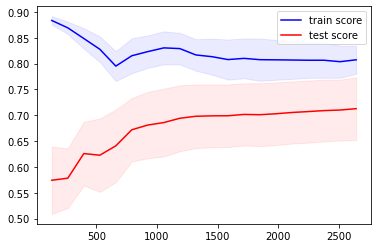

In [207]:
train_scores = lc_ridge[1].mean(axis = 1)
train_std = lc_ridge[1].std(axis = 1)
test_scores = lc_ridge[2].mean(axis = 1)
test_std = lc_ridge[2].std(axis = 1)


plt.plot(lc_ridge[0], train_scores, color='blue', label="train score")
plt.fill_between(lc_ridge[0], 
                 train_scores - train_std,
                 train_scores + train_std, alpha=0.08,
                 color="blue")

plt.plot(lc_ridge[0], test_scores, color='red', label="test score")
plt.fill_between(lc_ridge[0], 
                 test_scores - test_std,
                 test_scores + test_std, alpha=0.08,
                 color="red")
plt.legend()
plt.show()

In [200]:
lc_svr = learning_curve(svr2, X, y ,train_sizes = np.linspace(0.05, 1, 20))

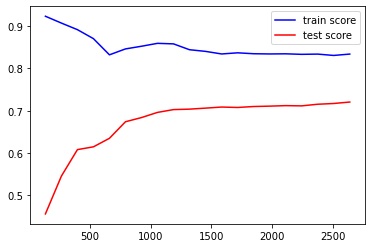

In [201]:
train_scores = lc_svr[1].mean(axis = 1)
test_scores = lc_svr[2].mean(axis = 1)

plt.plot(lc_svr[0], train_scores, color='blue', label="train score")
plt.plot(lc_svr[0], test_scores, color='red', label="test score")
plt.legend()
plt.show()

In [202]:
lc_xgb = learning_curve(rd_xgb, X, y ,train_sizes = np.linspace(0.05, 1, 20))

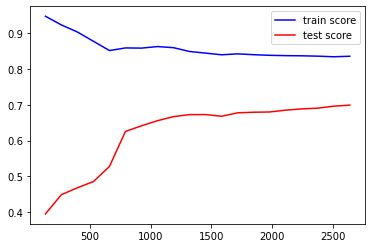

In [203]:
train_scores = lc_xgb[1].mean(axis = 1)
test_scores = lc_xgb[2].mean(axis = 1)

plt.plot(lc_xgb[0], train_scores, color='blue', label="train score")
plt.plot(lc_xgb[0], test_scores, color='red', label="test score")
plt.legend()
plt.show()